In [1]:
import pandas as pd
import numpy as np

# Provided constants
TICKS_PER_REVOLUTION = 16384.0
WHEEL_CIRCUMFERENCE = 1.59593
OUTPUT_INTERVAL = 100  # milliseconds

# Define the file paths
original_file_path = '/home/tractor/wheel_data_right.csv'
output_corrected_file_path = '/home/tractor/wheel_data_right_corrected.csv'

# Load the original data
df_original = pd.read_csv(original_file_path)

# Define the threshold values
threshold_prev_reading_3 = 15000
threshold_prev_reading_2 = 13000

# Function to capture previous three and next three position values
def capture_surrounding_values(df):
    results = []
    for i in range(len(df)):
        current_position = df.loc[i, 'current_position']
        previous_readings = df.loc[max(i-3, 0):i-1, 'current_position'].values
        next_readings = df.loc[i+1:i+3, 'current_position'].values
        
        # Ensure we capture exactly three values for previous and next readings
        previous_readings = [None]*(3-len(previous_readings)) + list(previous_readings)
        next_readings = list(next_readings) + [None]*(3-len(next_readings))
        
        results.append((i, current_position, previous_readings, next_readings))
    
    return results

# Function to detect forward motion sensor errors
def detect_fwd_errors(df_surrounding):
    errors = df_surrounding[
        (df_surrounding['Previous Reading 3'] > threshold_prev_reading_3) &
        (df_surrounding['Previous Reading 2'] > threshold_prev_reading_2) &
        (df_surrounding['Previous Reading 3'] > df_surrounding['Previous Reading 2']) &
        (df_surrounding['Previous Reading 2'] > df_surrounding['Previous Reading 1']) &
        (df_surrounding['Current Position'] > 2000) &
        (df_surrounding['Current Position'] < df_surrounding['Previous Reading 3'])
    ]
    return errors

# Function to correct forward motion sensor errors
def correct_fwd_errors(df, errors):
    corrected_positions = df['current_position'].copy()
    corrected_deltas = df['delta'].copy()
    corrected_speeds = df['speed'].copy()
    corrected_rotations = df['total_rotations'].copy()
    error_indices = errors['Index'].tolist()
    
    corrected_count = 0
    for idx in error_indices:
        if idx < 3 or idx >= len(df) - 3:
            continue
        
        # Calculate the average speed before the anomaly
        avg_speed = df.iloc[idx-3:idx]['speed'].mean()
        
        # Calculate the delta that would result in the average speed
        required_rotations_per_second = avg_speed / WHEEL_CIRCUMFERENCE
        required_delta = required_rotations_per_second * TICKS_PER_REVOLUTION * (OUTPUT_INTERVAL / 1000.0)
        required_delta = round(required_delta)
        
        # Calculate the expected current position based on the required delta
        last_position = df.iloc[idx-1]['current_position']
        expected_position = (last_position + required_delta) % TICKS_PER_REVOLUTION
        print(f"Required delta: {required_delta}, Expected position: {expected_position}")

        # Correct the current position
        corrected_positions[idx] = expected_position
        
        # Calculate delta using the corrected sensor reading for previous position and expected_position
        simulated_delta = (expected_position - last_position + TICKS_PER_REVOLUTION) % TICKS_PER_REVOLUTION
        if simulated_delta > TICKS_PER_REVOLUTION / 2:
            simulated_delta -= TICKS_PER_REVOLUTION
        
        corrected_deltas[idx] = simulated_delta
        
        # Calculate total rotations using the corrected sensor reading for previous position and expected_position
        corrected_rotations[idx] = df.iloc[idx-1]['total_rotations'] + simulated_delta / TICKS_PER_REVOLUTION
        
        # Calculate the new speed value for the corrected record
        rotations_per_second = simulated_delta / TICKS_PER_REVOLUTION * (1000.0 / OUTPUT_INTERVAL)
        corrected_speeds[idx] = rotations_per_second * WHEEL_CIRCUMFERENCE
        
        # Simulated next sensor reading
        next_sensor_reading = df.iloc[idx+1]['current_position']
        
        # Calculate delta using the corrected sensor reading for previous position and next_sensor_reading
        simulated_delta = (next_sensor_reading - expected_position + TICKS_PER_REVOLUTION) % TICKS_PER_REVOLUTION
        if simulated_delta > TICKS_PER_REVOLUTION / 2:
            simulated_delta -= TICKS_PER_REVOLUTION
        
        # Calculate the new speed value for the next record
        new_rotations_per_second = simulated_delta / TICKS_PER_REVOLUTION * (1000.0 / OUTPUT_INTERVAL)
        new_speed = new_rotations_per_second * WHEEL_CIRCUMFERENCE
        
        # Correct the speed and delta for the next record
        corrected_speeds[idx+1] = new_speed
        corrected_deltas[idx+1] = simulated_delta
        corrected_rotations[idx+1] = corrected_rotations[idx] + simulated_delta / TICKS_PER_REVOLUTION
        
        corrected_count += 1
        
        # Print the timestamp and index of the error
        error_timestamp = df.iloc[idx]['timestamp']
        time_delta = error_timestamp - df.iloc[0]['timestamp']
        print(f"Error detected at index {idx}, timestamp: {error_timestamp}, time delta: {time_delta} seconds")
    
    df['current_position'] = corrected_positions
    df['delta'] = corrected_deltas
    df['speed'] = corrected_speeds
    df['total_rotations'] = corrected_rotations
    
    return df, corrected_count

# Capture the surrounding values
surrounding_values = capture_surrounding_values(df_original)

# Create a DataFrame for the results
surrounding_values_data = {
    'Index': [t[0] for t in surrounding_values],
    'Previous Reading 1': [t[2][0] for t in surrounding_values],
    'Previous Reading 2': [t[2][1] for t in surrounding_values],
    'Previous Reading 3': [t[2][2] for t in surrounding_values],
    'Current Position': [t[1] for t in surrounding_values],
    'Next Reading 1': [t[3][0] for t in surrounding_values],
    'Next Reading 2': [t[3][1] for t in surrounding_values],
    'Next Reading 3': [t[3][2] for t in surrounding_values]
}
df_surrounding_values = pd.DataFrame(surrounding_values_data)

# Detect forward motion sensor errors
errors = detect_fwd_errors(df_surrounding_values)

# Correct forward motion sensor errors
df_corrected, corrected_count = correct_fwd_errors(df_original, errors)

# Save the corrected data to a new CSV file
df_corrected.to_csv(output_corrected_file_path, index=False)
print(f"Corrected data saved to {output_corrected_file_path}")
print(f"Number of corrected errors: {corrected_count}")

Required delta: 762, Expected position: 2.0
Error detected at index 1434, timestamp: 1721768998.7816494, time delta: 143.62779545783997 seconds
Required delta: 804, Expected position: 97.0
Error detected at index 1455, timestamp: 1721769000.8856125, time delta: 145.73175859451294 seconds
Required delta: 1159, Expected position: 48.0
Error detected at index 1509, timestamp: 1721769006.293924, time delta: 151.14007019996643 seconds
Required delta: 1121, Expected position: 69.0
Error detected at index 1524, timestamp: 1721769007.7966902, time delta: 152.64283633232117 seconds
Required delta: 1058, Expected position: 16229.0
Error detected at index 1602, timestamp: 1721769015.609926, time delta: 160.45607209205627 seconds
Required delta: 1023, Expected position: 323.0
Error detected at index 1784, timestamp: 1721769033.8418772, time delta: 178.68802332878113 seconds
Required delta: 207, Expected position: 20.0
Error detected at index 1942, timestamp: 1721769049.6682456, time delta: 194.514

In [14]:
import collections

# Provided constants
TICKS_PER_REVOLUTION = 16384.0
WHEEL_CIRCUMFERENCE = 1.59593
OUTPUT_INTERVAL = 100  # milliseconds

# Define the threshold values
threshold_prev_reading_1 = 14500
threshold_prev_reading_2 = 13000

# Initialize deque to store the previous three readings
previous_readings = collections.deque(maxlen=3)

# Function to detect forward motion sensor errors in real-time
def detect_fwd_errors_realtime(current_position):
    # Only process if we have at least three previous readings
    if len(previous_readings) < 3:
        return False

    # Extract the previous three readings from the deque
    prev_reading_3 = previous_readings[0]
    prev_reading_2 = previous_readings[1]
    prev_reading_1 = previous_readings[2]

    # Check the error conditions
    if (prev_reading_1 > threshold_prev_reading_1 and
        prev_reading_2 > threshold_prev_reading_2 and
        prev_reading_3 < prev_reading_2 and
        prev_reading_2 < prev_reading_1 and
        current_position > 2000 and
        current_position < prev_reading_1):
        return True
    
    # Check if the current position is equal to the previous position 1
    if current_position == prev_reading_1:
        return True

    return False

# Function to correct forward motion sensor errors
def correct_fwd_errors_realtime(current_position, previous_readings):
    # Initialize corrected values
    corrected_position = current_position
    corrected_delta = 0
    corrected_speed = 0
    corrected_rotation = 0

    # Calculate the average speed before the anomaly
    avg_speed = sum(previous_readings) / len(previous_readings)

    # Calculate the delta that would result in the average speed
    required_rotations_per_second = avg_speed / WHEEL_CIRCUMFERENCE
    required_delta = required_rotations_per_second * TICKS_PER_REVOLUTION * (OUTPUT_INTERVAL / 1000.0)
    required_delta = round(required_delta)

    # Calculate the expected current position based on the required delta
    last_position = previous_readings[-1]
    expected_position = (last_position + required_delta) % TICKS_PER_REVOLUTION
    print(f"Required delta: {required_delta}, Expected position: {expected_position}")

    # Correct the current position
    corrected_position = expected_position

    # Calculate delta using the corrected sensor reading for previous position and expected_position
    simulated_delta = (expected_position - last_position + TICKS_PER_REVOLUTION) % TICKS_PER_REVOLUTION
    if simulated_delta > TICKS_PER_REVOLUTION / 2:
        simulated_delta -= TICKS_PER_REVOLUTION

    corrected_delta = simulated_delta

    # Calculate total rotations using the corrected sensor reading for previous position and expected_position
    corrected_rotation = sum(previous_readings) + simulated_delta / TICKS_PER_REVOLUTION

    # Calculate the new speed value
    new_rotations_per_second = simulated_delta / TICKS_PER_REVOLUTION * (1000.0 / OUTPUT_INTERVAL)
    corrected_speed = new_rotations_per_second * WHEEL_CIRCUMFERENCE

    return corrected_position, corrected_delta, corrected_speed, corrected_rotation

# Example usage
current_positions = [10343, 11871, 13391, 14917, 6578, 1476]  # Example sensor readings

for current_position in current_positions:
    # Update the previous readings deque
    previous_readings.append(current_position)
    print(f"current_position: {current_position}")
    print(f"previous_readings: {previous_readings}")
    if detect_fwd_errors_realtime(current_position):
        corrected_position, corrected_delta, corrected_speed, corrected_rotation = correct_fwd_errors_realtime(current_position, list(previous_readings))
        print(f"Error detected at position {current_position}. Corrected to: {corrected_position}, Delta: {corrected_delta}, Speed: {corrected_speed}, Rotation: {corrected_rotation}")
    else:
        prev_reading_3 = previous_readings[0] if len(previous_readings) >= 3 else None
        prev_reading_2 = previous_readings[1] if len(previous_readings) >= 2 else None
        prev_reading_1 = previous_readings[2] if len(previous_readings) >= 3 else (previous_readings[0] if len(previous_readings) >= 1 else None)
        print(f"No error detected for position {current_position}. Previous 3: {prev_reading_3}, Previous 2: {prev_reading_2}, Previous 1: {prev_reading_1}")


current_position: 10343
previous_readings: deque([10343], maxlen=3)
No error detected for position 10343. Previous 3: None, Previous 2: None, Previous 1: 10343
current_position: 11871
previous_readings: deque([10343, 11871], maxlen=3)
No error detected for position 11871. Previous 3: None, Previous 2: 11871, Previous 1: 10343
current_position: 13391
previous_readings: deque([10343, 11871, 13391], maxlen=3)
Required delta: 12184167, Expected position: 7862.0
Error detected at position 13391. Corrected to: 7862.0, Delta: -5529.0, Speed: -5.385679302978516, Rotation: 35604.662536621094
current_position: 14917
previous_readings: deque([11871, 13391, 14917], maxlen=3)
Required delta: 13749407, Expected position: 1764.0
Error detected at position 14917. Corrected to: 1764.0, Delta: 3231.0, Speed: 3.1472472106933593, Rotation: 40179.197204589844
current_position: 6578
previous_readings: deque([13391, 14917, 6578], maxlen=3)
Required delta: 11938122, Expected position: 764.0
Error detected at 

## Understanding Acceleration and G-Forces

Acceleration, often measured in meters per second squared (m/s²), can be compared to gravitational acceleration, commonly referred to as "G's" (1 G ≈ 9.81 m/s² on Earth). To calculate the G-force experienced by your robot, you need to measure its acceleration and then normalize it by the gravitational acceleration.

### Calculating G's

The G-force experienced by an object can be calculated using the formula:

$ G = \frac{a}{g} $

where:  
- **\( a \)** is the acceleration of the object (in m/s²)  
- **\( g \)** is the acceleration due to gravity (approximately 9.81 m/s² on Earth)  

### Required Data

To calculate the G-force your robot experiences, you need the following data:  
1. **Velocity Data**: Continuous measurements of the robot's speed.  
2. **Time Intervals**: The time intervals at which the velocity data is recorded.  
3. **Acceleration Data**: This can be derived from the velocity data over time.  

### Calculating Acceleration

If you have velocity data at different time intervals, you can calculate the acceleration using the following formula:

$ a = \frac{\Delta v}{\Delta t} $

where:  
- **\( \Delta v \)** is the change in velocity (final velocity - initial velocity)  
- **\( \Delta t \)** is the change in time (final time - initial time)  

### Filtering Bad Data

Once you have the acceleration data, you can calculate the corresponding G-force. If the G-force exceeds a certain threshold that you deem physically unrealistic for your robot's operations, you can filter out these readings. For example, if you determine that your robot should not experience more than 2 G's under normal operation, you can filter out any readings where the calculated G-force exceeds this value.

### Practical Steps

1. **Collect Data**: Gather velocity data from your wheel sensor at consistent time intervals.  
2. **Calculate Acceleration**: Compute the acceleration using the change in velocity over each time interval.  
3. **Normalize Acceleration**: Divide the calculated acceleration by the gravitational acceleration (9.81 m/s²) to get the G-force.  
4. **Filter Data**: Set a threshold for the G-force (e.g., 2 G's) and filter out any readings that exceed this threshold.


In [2]:
import pandas as pd

# Example velocity data (in m/s) and time intervals (in seconds)
velocity_data = [1.0, 1.2, 0.8, 1.1, 5.0]  # Example velocities
time_intervals = [1, 1, 1, 1, 1]  # Assuming constant time intervals of 1 second

# Calculate acceleration
acceleration = [(velocity_data[i] - velocity_data[i-1]) / time_intervals[i] for i in range(1, len(velocity_data))]

# Calculate G-force
g_force = [acc / 9.81 for acc in acceleration]

# Set threshold for filtering
threshold_g = 2  # Example threshold of 2 G's

# Filter out bad data
filtered_data = [g for g in g_force if abs(g) <= threshold_g]

# Display results
print("Calculated G-force:", g_force)
print("Filtered G-force (<= 2 G's):", filtered_data)


Calculated G-force: [0.020387359836901115, -0.04077471967380223, 0.030581039755351685, 0.39755351681957185]
Filtered G-force (<= 2 G's): [0.020387359836901115, -0.04077471967380223, 0.030581039755351685, 0.39755351681957185]


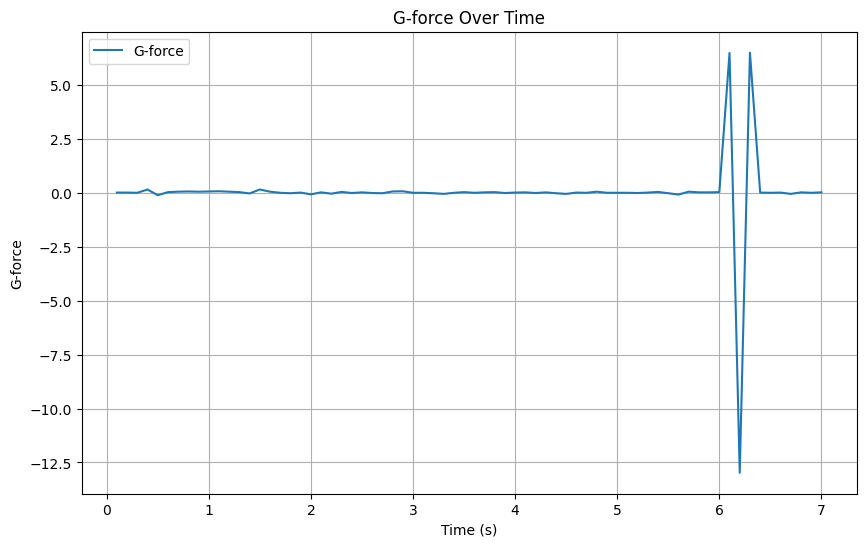

In [3]:
import matplotlib.pyplot as plt

# Sample speed data
speed_data = [
    0.00, 0.01, 0.02, 0.02, 0.17, 0.06, 0.09, 0.14, 0.20, 0.25, 0.31, 0.38, 0.43, 0.46, 0.43, 0.58, 0.63, 0.63, 0.61, 0.62,
    0.55, 0.57, 0.53, 0.57, 0.56, 0.58, 0.57, 0.55, 0.61, 0.68, 0.68, 0.68, 0.66, 0.61, 0.61, 0.64, 0.64, 0.66, 0.69, 0.68,
    0.69, 0.71, 0.70, 0.72, 0.70, 0.65, 0.66, 0.66, 0.71, 0.71, 0.71, 0.71, 0.70, 0.71, 0.75, 0.73, 0.65, 0.70, 0.72, 0.74,
    0.77, 7.13, -5.60, 0.77, 0.78, 0.78, 0.79, 0.74, 0.76, 0.76, 0.78
]

# Constants
g = 9.81  # Acceleration due to gravity (m/s²)
time_interval = 0.1  # Time interval between measurements (s) - 10 Hz

# Calculate acceleration
acceleration = [(speed_data[i] - speed_data[i-1]) / time_interval for i in range(1, len(speed_data))]

# Calculate G-force
g_force = [acc / g for acc in acceleration]

# Time data for plotting
time_data = [i * time_interval for i in range(1, len(speed_data))]

# Plotting G-force over time
plt.figure(figsize=(10, 6))
plt.plot(time_data, g_force, label='G-force')
plt.xlabel('Time (s)')
plt.ylabel('G-force')
plt.title('G-force Over Time')
plt.legend()
plt.grid(True)
plt.show()


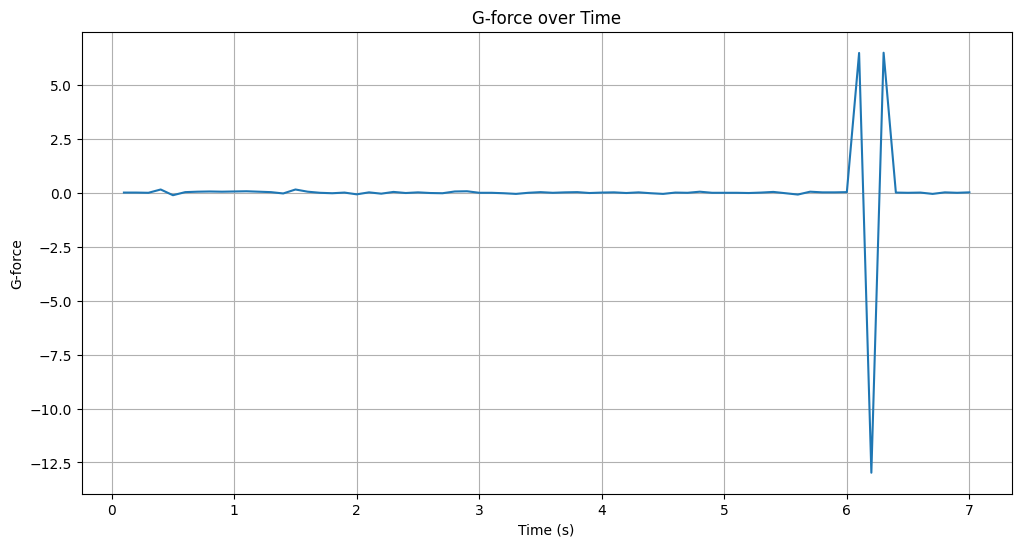

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Speed data
speeds = [
    0.00, 0.01, 0.02, 0.02, 0.17, 0.06, 0.09, 0.14, 0.20, 0.25,
    0.31, 0.38, 0.43, 0.46, 0.43, 0.58, 0.63, 0.63, 0.61, 0.62,
    0.55, 0.57, 0.53, 0.57, 0.56, 0.58, 0.57, 0.55, 0.61, 0.68,
    0.68, 0.68, 0.66, 0.61, 0.61, 0.64, 0.64, 0.66, 0.69, 0.68,
    0.69, 0.71, 0.70, 0.72, 0.70, 0.65, 0.66, 0.66, 0.71, 0.71,
    0.71, 0.71, 0.70, 0.71, 0.75, 0.73, 0.65, 0.70, 0.72, 0.74,
    0.77, 7.13, -5.60, 0.77, 0.78, 0.78, 0.79, 0.74, 0.76, 0.76, 0.78
]

# Calculate time array (10 Hz sampling rate)
time = np.arange(0, len(speeds) / 10, 0.1)

# Calculate acceleration (m/s^2)
acceleration = np.diff(speeds) / 0.1

# Convert acceleration to G-force (1 G = 9.81 m/s^2)
g_force = acceleration / 9.81

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time[1:], g_force)
plt.title('G-force over Time')
plt.xlabel('Time (s)')
plt.ylabel('G-force')
plt.grid(True)

# Show the plot
plt.show()

In [8]:
import pandas as pd

# File path
file_path = '/home/tractor/wheel_data_right_with_gforce.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Count the total number of records
total_records = df.shape[0]

# Count the number of records with G-Force > 3
count_greater_than_3 = df[df['G_Force'] > 3].shape[0]

# Count the number of records with G-Force < -3
count_less_than_minus_3 = df[df['G_Force'] < -3].shape[0]

print(f"Total number of records: {total_records}")
print(f"Number of records with G-Force > 3: {count_greater_than_3}")
print(f"Number of records with G-Force < -3: {count_less_than_minus_3}")

Total number of records: 4482
Number of records with G-Force > 3: 40
Number of records with G-Force < -3: 32
